In [2]:
import numpy as np
from view_sampler import ViewSampler, CameraConfig
from manipulated_object import ObjectPosition
from utils.orient import OrientUtils
from evaluate.evaluator import Evaluator
import loss_funcs
import cv2 as cv

from utils.image import ImageUtils
from tqdm.auto import tqdm
from collections import defaultdict 

In [3]:
INIT_LOCATION = (0, 1.3, 0.3)

LOSS_FUNCTIONS = [
    loss_funcs.IOU(),
    loss_funcs.MSE(),
    loss_funcs.NormMSE(norm="euclidean"),
    loss_funcs.MutualInformation(bins=100),
    loss_funcs.PeakSignalNoiseRatio(),
    loss_funcs.StructuralSimilarity(),
    loss_funcs.HausdorffDistance(),
    loss_funcs.AdaptedRandError(),
    loss_funcs.VariationOfInformation(),
]

OBJECTS = ["airplane", "hammer", "hand", "headphones", "mouse", "mug", "stapler", "toothpaste"]

ZFAR = 5

In [4]:
def create_viewer(obj_name: str, is_sim: bool = True) -> ViewSampler:
    location = (INIT_LOCATION[0], INIT_LOCATION[2] - 1.3, INIT_LOCATION[2])
    cam_config = CameraConfig(location, rotation=(np.pi / 2, 0, 0), fov=30, zfar=ZFAR)
    if is_sim:
        viewer = ViewSampler(f"data/{obj_name}/world_sim.xml", cam_config, simulation_time=0)
    else:
        viewer = ViewSampler(f"data/{obj_name}/world.xml", cam_config, simulation_time=0)
    return viewer

In [5]:
def generate_positions(count: int, ) -> list[ObjectPosition]:
    orients = OrientUtils.generate_random(count)
    positions = [ObjectPosition(orient, INIT_LOCATION) for orient in orients]
    return positions

In [6]:
def get_views(viewer: ViewSampler, pos1: ObjectPosition, pos2: ObjectPosition, depth: bool) -> tuple[np.ndarray, np.ndarray]:
    img1, _ = viewer.get_view_cropped(pos1, depth=depth, allow_simulation=False)
    img2, _ = viewer.get_view_cropped(pos2, depth=depth, allow_simulation=False)
    pad_shape = np.maximum(img1.shape, img2.shape)
    img1 = ImageUtils.pad_to_shape(img1, pad_shape)
    img2 = ImageUtils.pad_to_shape(img2, pad_shape)
    return img1, img2

In [7]:
import pickle
from pathlib import Path

def save(file_path: str, obj):
    Path(file_path).parent.mkdir(parents=True, exist_ok=True)

    try:
        with open(file_path, "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        raise ValueError(f"error saving object to pickle file: {e}")

def load(file_path: str) -> object:
    try:
        with open(file_path, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"file does not exist: {file_path}")
    except Exception as e:
        raise ValueError(f"error loading object from pickle file: {e}")

In [7]:
N = 200
positions1 = generate_positions(N)
positions2 = generate_positions(N)

In [8]:
from evaluate import eval_funcs
from utils.image import ImageUtils

eval_func = eval_funcs.XorDiff(0.1)
eval_results = []

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name) as sim_viewer:
        for pos1, pos2 in tqdm(zip(positions1, positions2), total=N):
            img1, img2 = get_views(sim_viewer, pos1, pos2, depth=True)
            result = eval_func(img1, img2)
            eval_results.append(result)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
loss_results = defaultdict(list)

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name) as sim_viewer:
        for pos1, pos2 in tqdm(zip(positions1, positions2), total=N):
            img1, img2 = get_views(sim_viewer, pos1, pos2, depth=False)
            for loss_func in LOSS_FUNCTIONS:
                result = loss_func(img1, img2)
                loss_results[type(loss_func).__name__].append(result)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
for k, loss_vals in loss_results.items():
    eval_vals = np.asanyarray(eval_results)
    loss_vals = np.asanyarray(loss_vals)
    print(k, np.corrcoef(eval_vals, loss_vals)[0, 1])

IOU 0.6146595064182404
MSE 0.33221146667351803
NormMSE 0.5488251557087639
MutualInformation 0.589400409643714
PeakSignalNoiseRatio 0.38917981398905316
StructuralSimilarity -0.018232979537918165
HausdorffDistance 0.4246519915179914
AdaptedRandError 0.242769532179986
VariationOfInformation -0.19554810569352934


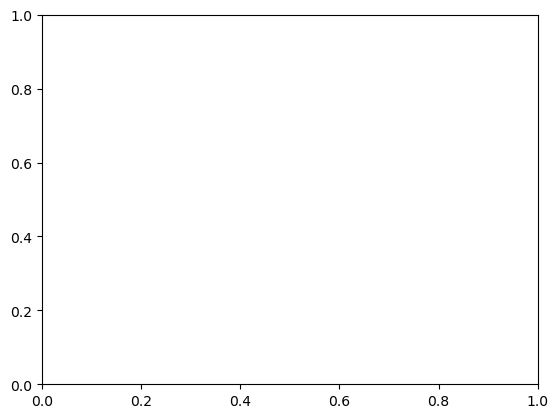

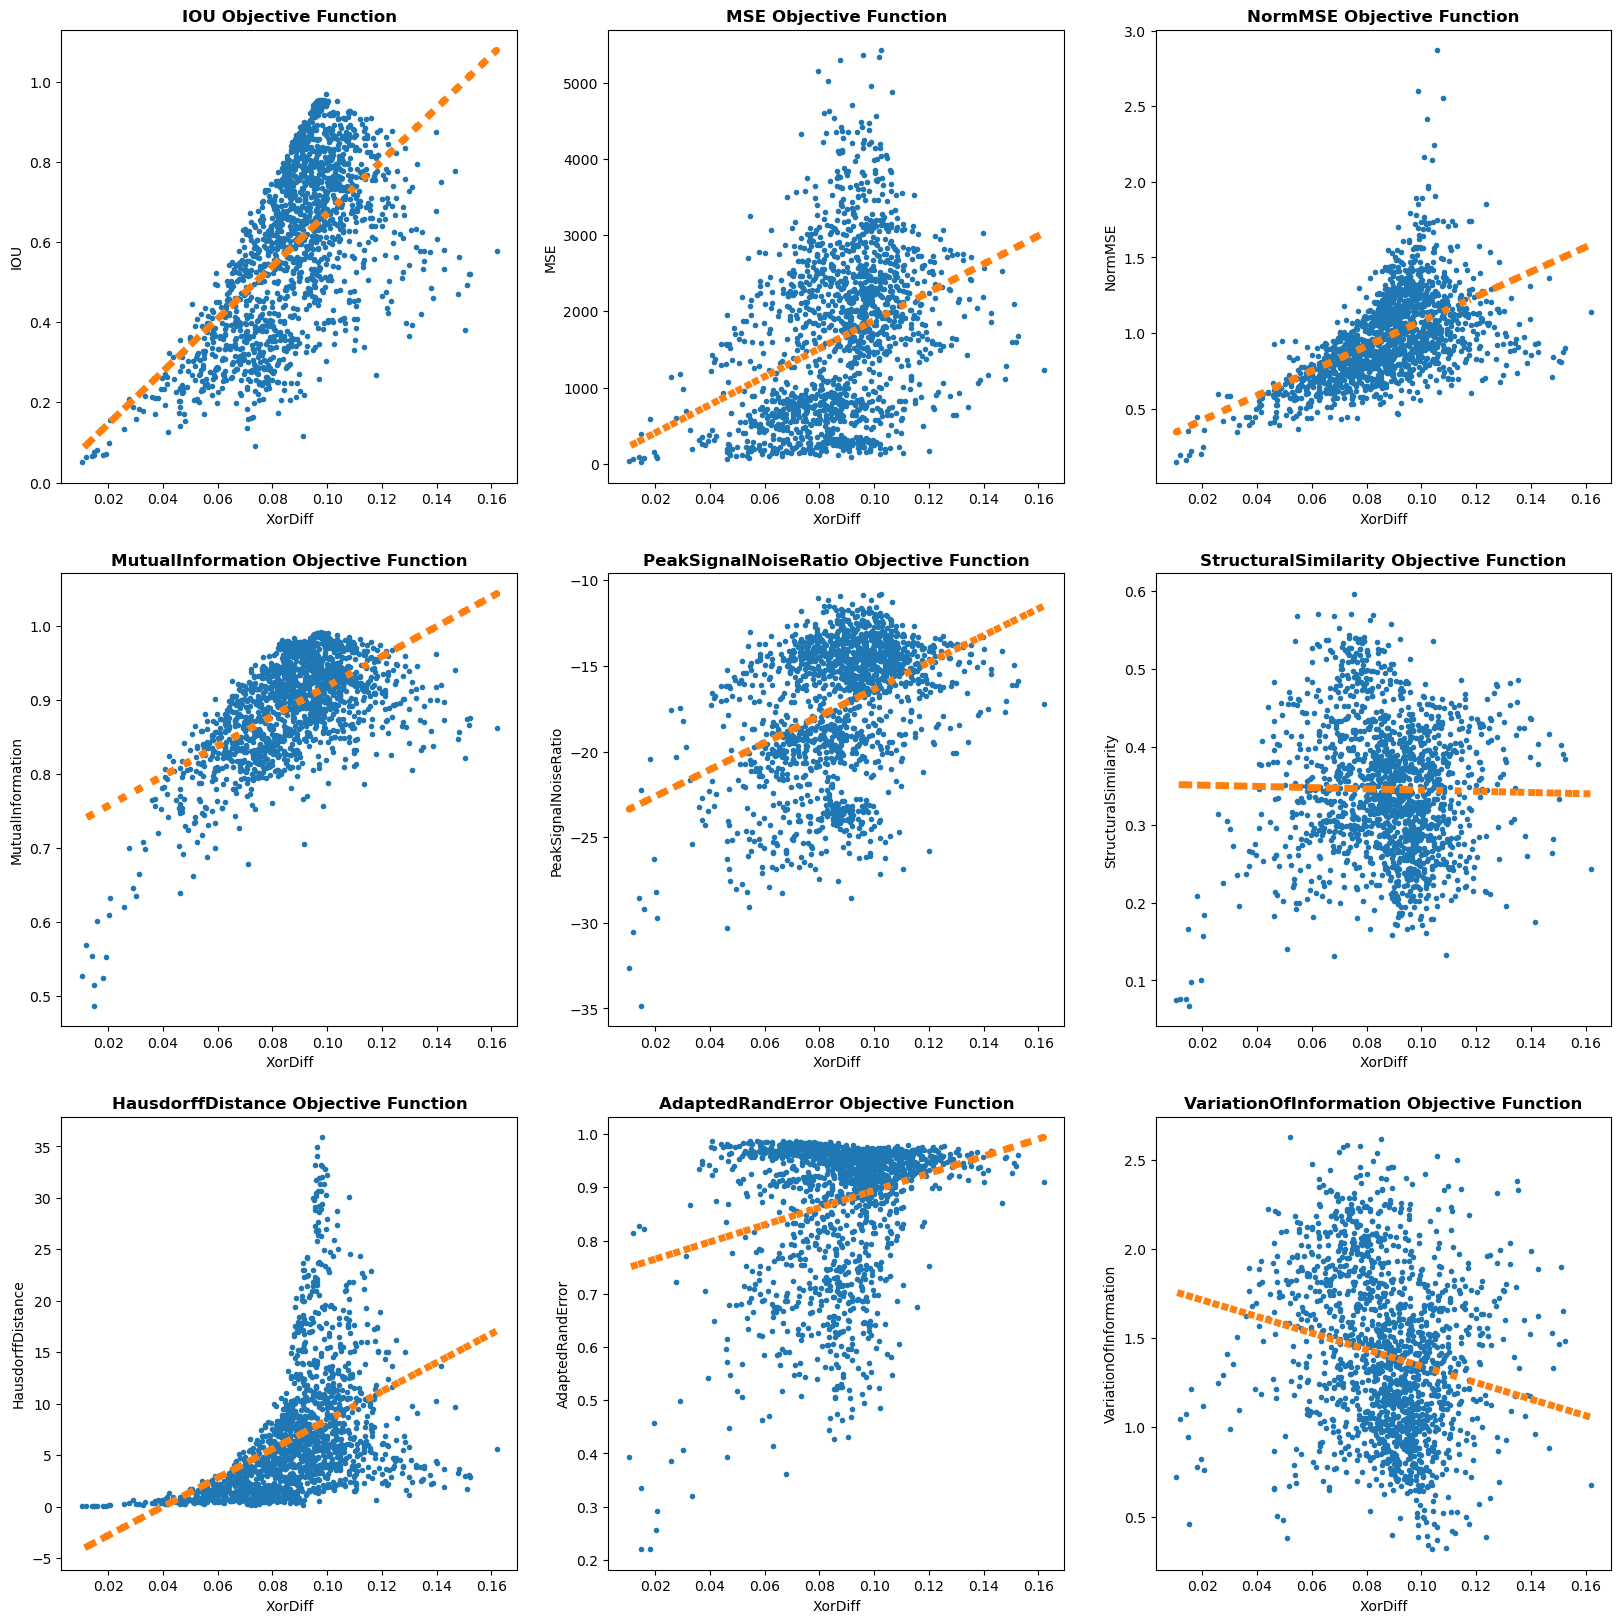

In [13]:
from matplotlib import pyplot as plt

font = {'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.rcParams['text.usetex'] = False

plt.cla()
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(20, 20))

for i, (loss, values) in enumerate(loss_results.items()):
    ax = axes[i // 3, i % 3]
    ax.set_xlabel("XorDiff")
    ax.set_ylabel(loss)
    ax.set_title(f"{loss} Objective Function", fontweight='bold')

    x = eval_results
    y = np.polyval(np.polyfit(x, values, 1), x)

    ax.plot(x, values, '.', label=loss, markersize=6)
    ax.plot(x, y, ":", linewidth=5)


In [10]:
from algs.uniform_sampling import UniformSampling
from evaluate import eval_funcs

alg_config = UniformSampling.Config(time_limit=1000, min_samples=343, randomized=False, silent=True)

eval_positions = generate_positions(75)

results = defaultdict(lambda: defaultdict(list))

SELECTED_LOSSES = [
    loss_funcs.IOU(),
    loss_funcs.NormMSE(norm="euclidean"),
    loss_funcs.MutualInformation(bins=100),
    loss_funcs.HausdorffDistance(),
]

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name, True) as sim_viewer, create_viewer(obj_name, False) as world_viewer:
        for loss_func in SELECTED_LOSSES:
            alg = UniformSampling(sim_viewer, loss_func=loss_func)
            evaluator = Evaluator(world_viewer, eval_func=eval_funcs.XorDiff(0.1))
            losses = evaluator.evaluate(alg, alg_config, eval_positions)
            results[obj_name][type(loss_func).__name__].extend(losses)

  0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Algorithm: UniformSampling
Alg Config: UniformSampling.Config(time_limit=1000, rnd_seed=None, silent=True, min_samples=343, randomized=False)
Loss Function: IOU


Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(results.keys())
print(results[results.keys()[0]].keys())

dict_keys(['IOU', 'MSE', 'NormMSE', 'MutualInformation', 'PeakSignalNoiseRatio', 'StructuralSimilarity', 'HausdorffDistance', 'AdaptedRandError', 'VariationOfInformation'])


In [ ]:
import statistics

for loss, eval_values in results.items():
    print(f"{loss}: {statistics.mean(eval_values)}")
    print(f"{loss}: {statistics.median(eval_values)}")

IOU: 0.06708140741680263
IOU: 0.05914211744580654
MSE: 0.07165385142509802
MSE: 0.06919868697484452
NormMSE: 0.06921867761178886
NormMSE: 0.06630259108372416
MutualInformation: 0.0619448296701556
MutualInformation: 0.05580594248263671
PeakSignalNoiseRatio: 0.07224000240386348
PeakSignalNoiseRatio: 0.06954277072442483
StructuralSimilarity: 0.0716229105748495
StructuralSimilarity: 0.07478539090582045
HausdorffDistance: 0.06724793172470116
HausdorffDistance: 0.05920861469906244
AdaptedRandError: 0.06575006866183526
AdaptedRandError: 0.06414785399987699
VariationOfInformation: 0.07651645672579518
VariationOfInformation: 0.08111964892667216


Text(0, 0.5, 'XorDiff')

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

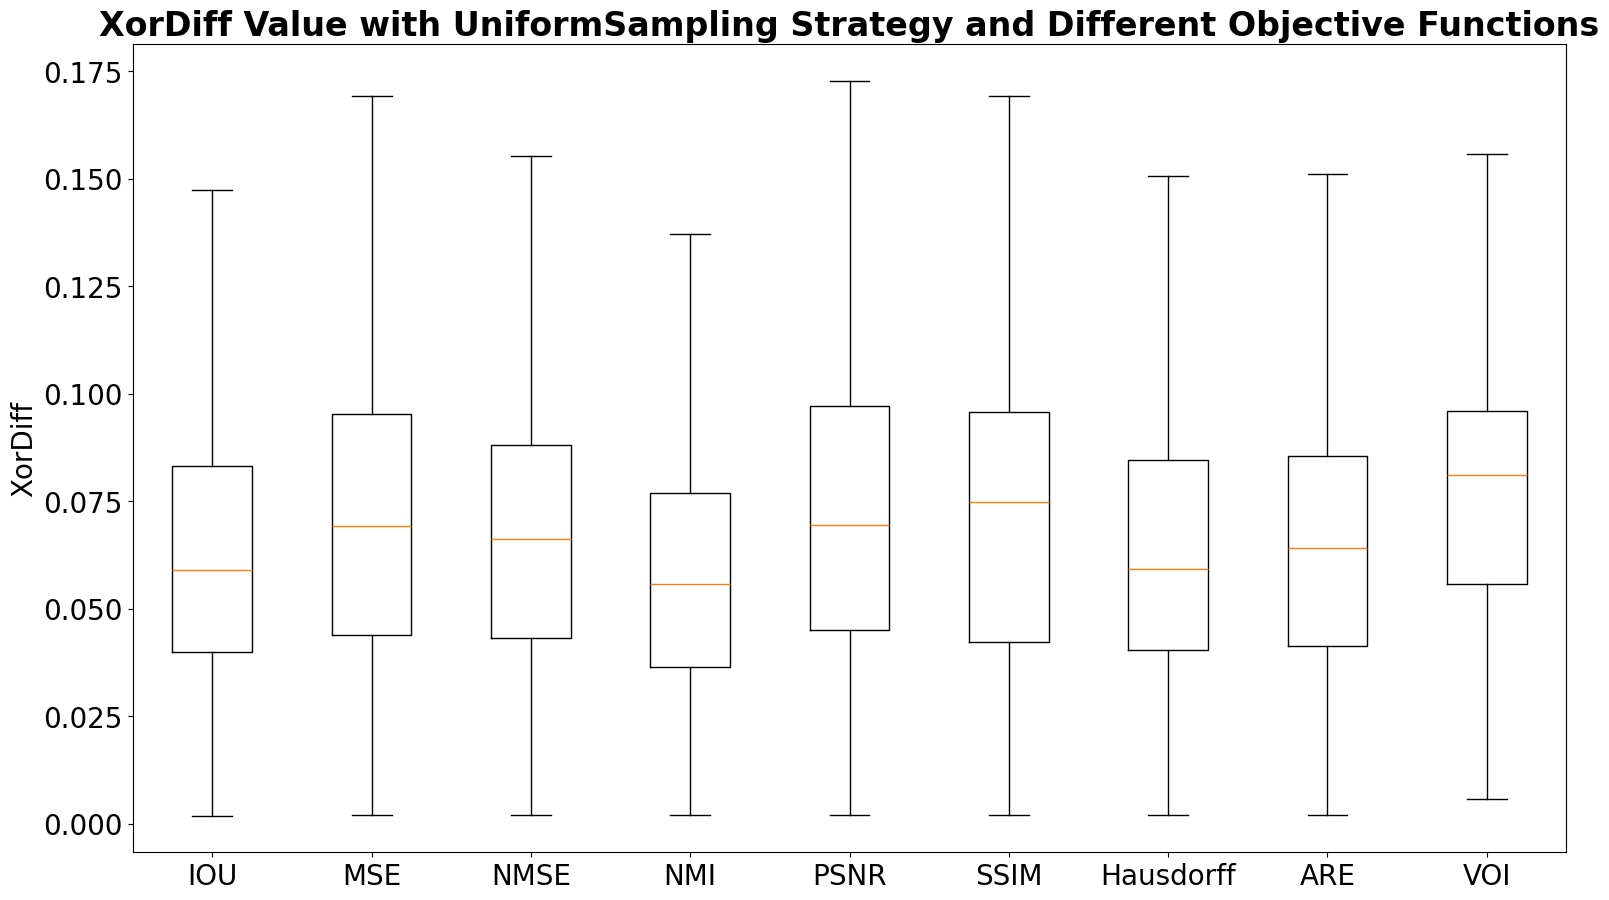

In [ ]:
from matplotlib import pyplot as plt

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

ax = plt.subplot(111)

ax.set_title('XorDiff Value with UniformSampling Strategy and Different Objective Functions', fontweight='bold')
ax.boxplot(results.values(), labels=results.keys(), sym="", patch_artist=False, autorange=True)
ax.set_ylabel('XorDiff')